# Classification

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, load_iris,make_classification
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.inspection import DecisionBoundaryDisplay
except ImportError:
    print("Scikit-Learn version is older than 1.1. Please update and re-run the notebook.")

## SVM Linéaire

Ici, $C$ représente une contrainte sur les marges dans le cas où celles-ci sont mal classifiés dans le cas d'un hyperplan. On qualifie cela de marge souple.

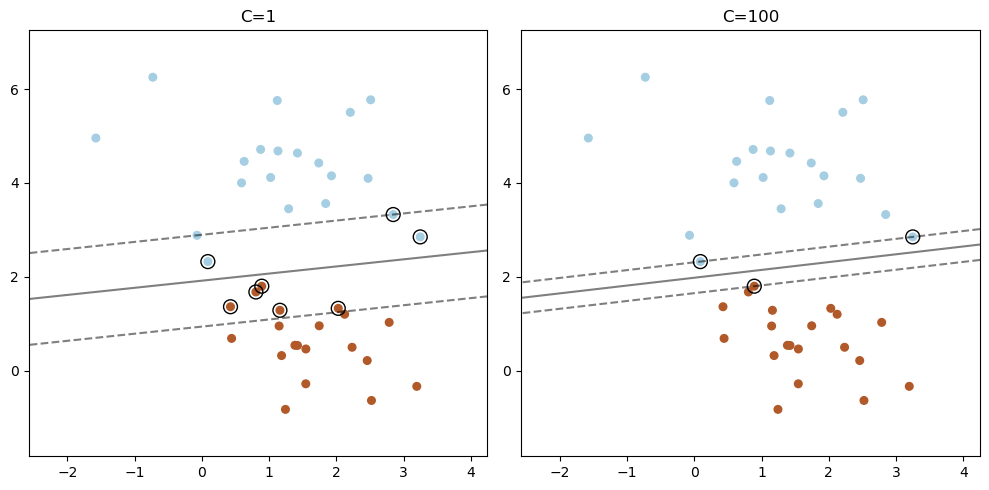

In [42]:


X, y = make_blobs(n_samples=40, centers=2, random_state=0)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

## Effet du Kernel Trick

On présente ici un cas simple où la transformation est triviale.

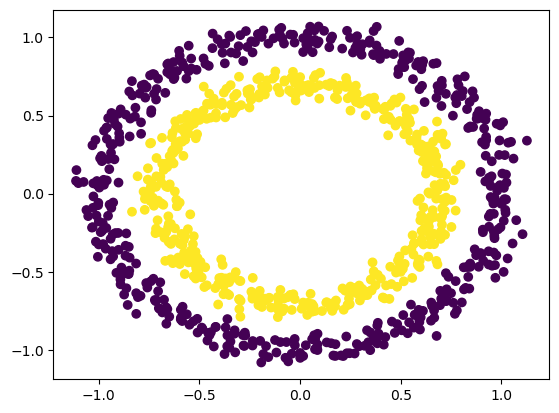

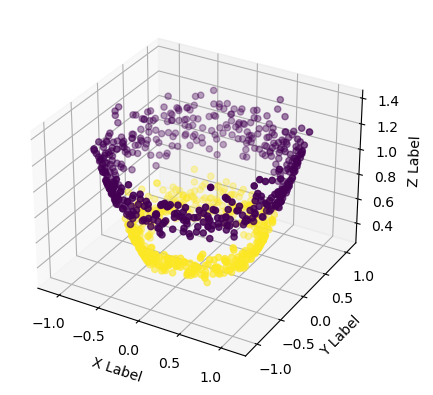

In [43]:
X, y = make_circles(n_samples=1_000, factor=0.7, noise=0.05, random_state=0)
X0, X1 = X[:, 0], X[:, 1]
plt.scatter(X0,X1,c = y)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
n = 100


ax.scatter(X0, X1, X0**2 + X1**2, c=y)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


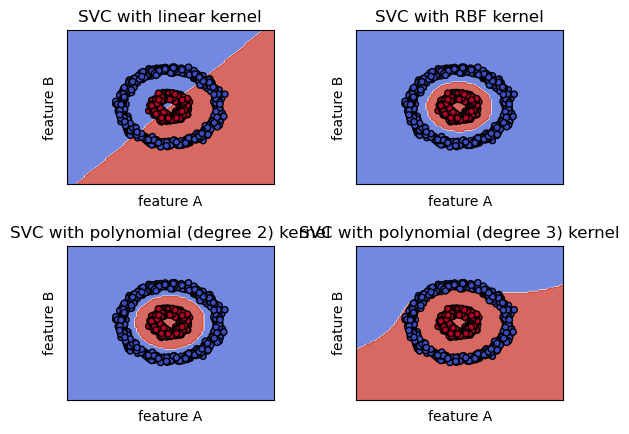

In [44]:
# import some data to play with
X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    LinearSVC(C=C, max_iter=10000),
    SVC(kernel="rbf", gamma=0.7, C=C),
    SVC(kernel="poly", degree=2, gamma="auto", C=C),
    SVC(kernel="poly", degree=3, gamma="auto", C=C),

)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 2) kernel",
    "SVC with polynomial (degree 3) kernel",

)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="feature A",
        ylabel="feature B"
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Kernel Trick en (presque) vrai

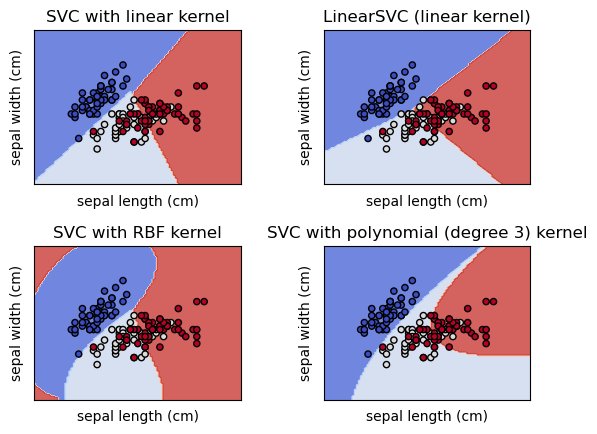

In [45]:

# import some data to play with
iris = load_iris()
# Take the first two features. 
# We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

C = 1.0  # SVM regularization parameter
models = (
    SVC(kernel="linear", C=C),
    LinearSVC(C=C, max_iter=10000),
    SVC(kernel="rbf", gamma=0.7, C=C),
    SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

# Méthode de validation

## Over et underfitting

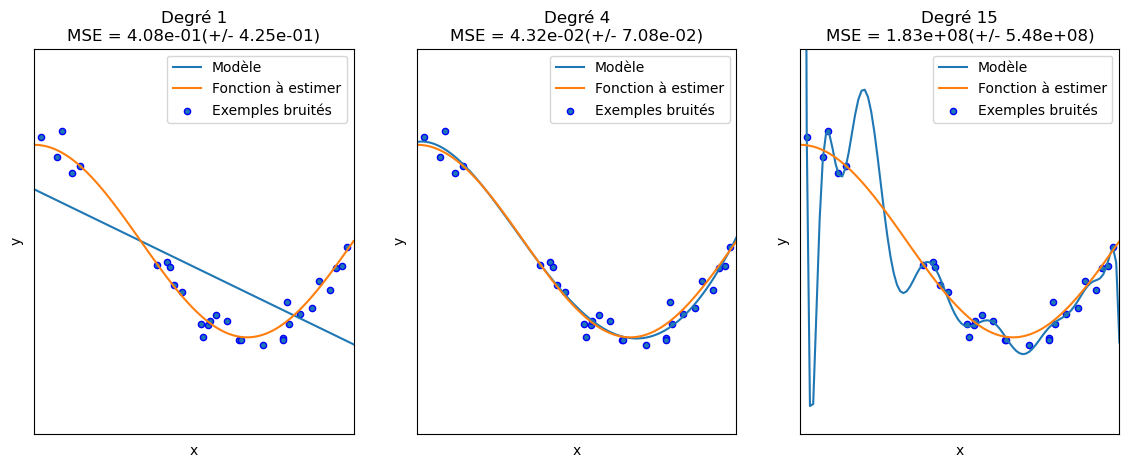

In [46]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1 # fonction bruitée

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation, cv=10 means K-fold underneath
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Modèle")
    plt.plot(X_test, true_fun(X_test), label="Fonction à estimer")
    plt.scatter(X, y, edgecolor="b", s=20, label="Exemples bruités")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degré {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()


## Sélection

In [39]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0) # Shuffle split

print("#"*80)
print(f"Tailles des données : {X.shape}, {y.shape}")
print(f"Tailles des données d'entrainement : {X_train.shape}, {y_train.shape}")
print(f"Tailles des données de validation : {X_test.shape}, {y_test.shape}")
print("#"*80)

clf = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(f"""Précision sur les données d'entrainement : {clf.score(X_train, y_train):.2f}
Précision sur les données de validation {clf.score(X_test, y_test):.2f}""")
      
print("#"*80)



################################################################################
Tailles des données : (150, 4), (150,)
Tailles des données d'entrainement : (90, 4), (90,)
Tailles des données de validation : (60, 4), (60,)
################################################################################
Précision sur les données d'entrainement : 0.99
Précision sur les données de validation 0.97
################################################################################


In [54]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(iris.data, iris.target)
clf.cv_results_, clf.best_params_

({'mean_fit_time': array([0.00091944, 0.00080047, 0.00064087, 0.00062494]),
  'std_fit_time': array([2.24571652e-04, 1.07464233e-04, 4.82766716e-05, 3.83749942e-05]),
  'mean_score_time': array([0.00058138, 0.00045023, 0.00039165, 0.00041382]),
  'std_score_time': array([1.44502322e-04, 4.26105697e-05, 3.68459774e-05, 7.44768697e-05]),
  'param_C': masked_array(data=[1, 1, 10, 10],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'C': 1, 'kernel': 'linear'},
   {'C': 1, 'kernel': 'rbf'},
   {'C': 10, 'kernel': 'linear'},
   {'C': 10, 'kernel': 'rbf'}],
  'split0_test_score': array([1., 1., 1., 1.]),
  'split1_test_score': array([0.93333333, 0.93333333, 1.        , 0.93333333]),
  'split2_test_score': array([1., 1., 1., 1.]),
  'split3_test_score

## Métriques

### Classification

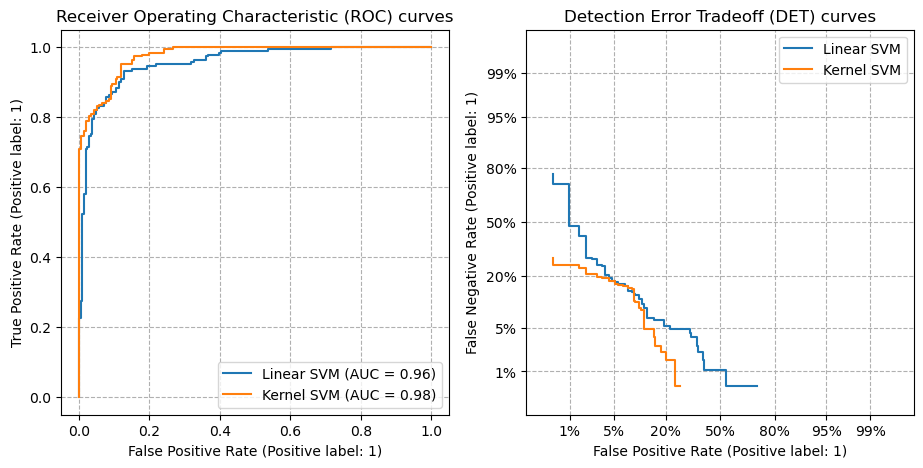

In [55]:
# Fake dataset
X, y = make_classification(
    n_samples=1_000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=1,
)

# Shuffle split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Kernel SVM": make_pipeline(StandardScaler(), SVC(C=0.025)),

}

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
